# MORBO-ENN: Multi-Objective Optimization

This notebook demonstrates multi-objective Bayesian optimization using the MORBO trust region with ENN surrogate.

---

In [1]:
import numpy as np


def ackley_core(
    x: np.ndarray, a: float = 20.0, b: float = 0.2, c: float = 2 * np.pi
) -> np.ndarray:
    if x.ndim == 1:
        x = x[None, :]
    x = x - 1
    term1 = -a * np.exp(-b * np.sqrt((x**2).mean(axis=1)))
    term2 = -np.exp(np.cos(c * x).mean(axis=1))
    return term1 + term2 + a + np.e


class DoubleAckley:
    def __init__(self, noise: float, rng):
        self.noise = noise
        self.rng = rng
        self.bounds = [-32.768, 32.768]

    def __call__(self, x: np.ndarray) -> np.ndarray:
        x = np.asarray(x, dtype=float)
        if x.ndim == 1:
            x = x[None, :]
        n, d = x.shape
        assert d % 2 == 0, "num_dim must be even for DoubleAckley"

        mid = d // 2
        x1 = x[:, :mid]
        x2 = x[:, mid:]

        y1 = -ackley_core(x1) + self.noise * self.rng.normal(size=n)
        y2 = -ackley_core(x2) + self.noise * self.rng.normal(size=n)

        return np.stack([y1, y2], axis=1)

In [2]:
import torch
from botorch.utils.multi_objective.hypervolume import Hypervolume
from nds import ndomsort


def get_pareto_front_indices(y: np.ndarray) -> np.ndarray:
    front_ids = ndomsort.non_domin_sort(-y, only_front_indices=True)
    return np.array([i for i, f in enumerate(front_ids) if f == 0])


def compute_hypervolume(y: np.ndarray, ref_point: np.ndarray) -> float:
    if len(y) == 0:
        return 0.0

    pareto_idx = get_pareto_front_indices(y)
    if len(pareto_idx) == 0:
        return 0.0

    pareto_y = y[pareto_idx]
    pareto_y_tensor = torch.tensor(pareto_y, dtype=torch.float64)
    ref_point_tensor = torch.tensor(ref_point, dtype=torch.float64)

    hv = Hypervolume(ref_point=ref_point_tensor)
    return hv.compute(pareto_y_tensor)

In [3]:
import time

from enn import Turbo, TurboMode
from enn.turbo.turbo_config import TurboConfig


def run_optimization(turbo_mode: TurboMode):
    num_dim = 30
    num_iterations = 100
    num_arms = 10
    noise = 0.1
    ref_point = np.array([-25.0, -25.0])

    rng = np.random.default_rng(42)
    objective = DoubleAckley(noise=noise, rng=rng)
    bounds = np.array([objective.bounds] * num_dim, dtype=float)

    config = TurboConfig(
        k=10,
        num_fit_samples=100,
        acq_type="ucb",
        tr_type="morbo",
    )
    optimizer = Turbo(bounds=bounds, mode=turbo_mode, rng=rng, config=config)

    all_y = []
    hypervolume_history = []
    proposal_times = []

    for iteration in range(num_iterations):
        t0 = time.time()
        x_arms = optimizer.ask(num_arms=num_arms)
        proposal_times.append(time.time() - t0)

        y_obs = objective(x_arms)
        optimizer.tell(x_arms, y_obs)

        all_y.append(y_obs)
        hv = compute_hypervolume(np.vstack(all_y), ref_point)
        hypervolume_history.append(hv)

        if iteration % 10 == 0:
            print(f"{turbo_mode.name} iter {iteration:3d}: HV = {hv:.2f}")

    evals = num_arms * np.arange(1, len(hypervolume_history) + 1)
    return hypervolume_history, proposal_times, evals

In [4]:
RUN_TURBO_ONE = False

modes = [TurboMode.TURBO_ENN, TurboMode.LHD_ONLY, TurboMode.TURBO_ZERO]
if RUN_TURBO_ONE:
    modes.append(TurboMode.TURBO_ONE)

results = {}
for mode in modes:
    hv, times, evals = run_optimization(mode)
    results[mode] = {"hv": hv, "times": times, "evals": evals}

TURBO_ENN iter   0: HV = 18.46
TURBO_ENN iter  10: HV = 23.67
TURBO_ENN iter  20: HV = 26.33
TURBO_ENN iter  30: HV = 29.42
TURBO_ENN iter  40: HV = 57.54
TURBO_ENN iter  50: HV = 120.15
TURBO_ENN iter  60: HV = 130.99
TURBO_ENN iter  70: HV = 130.99
TURBO_ENN iter  80: HV = 130.99
TURBO_ENN iter  90: HV = 130.99
LHD_ONLY iter   0: HV = 18.46
LHD_ONLY iter  10: HV = 22.64
LHD_ONLY iter  20: HV = 22.78
LHD_ONLY iter  30: HV = 27.07
LHD_ONLY iter  40: HV = 27.11
LHD_ONLY iter  50: HV = 27.16
LHD_ONLY iter  60: HV = 27.22
LHD_ONLY iter  70: HV = 27.32
LHD_ONLY iter  80: HV = 27.33
LHD_ONLY iter  90: HV = 27.40
TURBO_ZERO iter   0: HV = 18.46
TURBO_ZERO iter  10: HV = 28.71
TURBO_ZERO iter  20: HV = 41.45


RuntimeError: scalarize called before any observations

## Hypervolume vs Function Evaluations

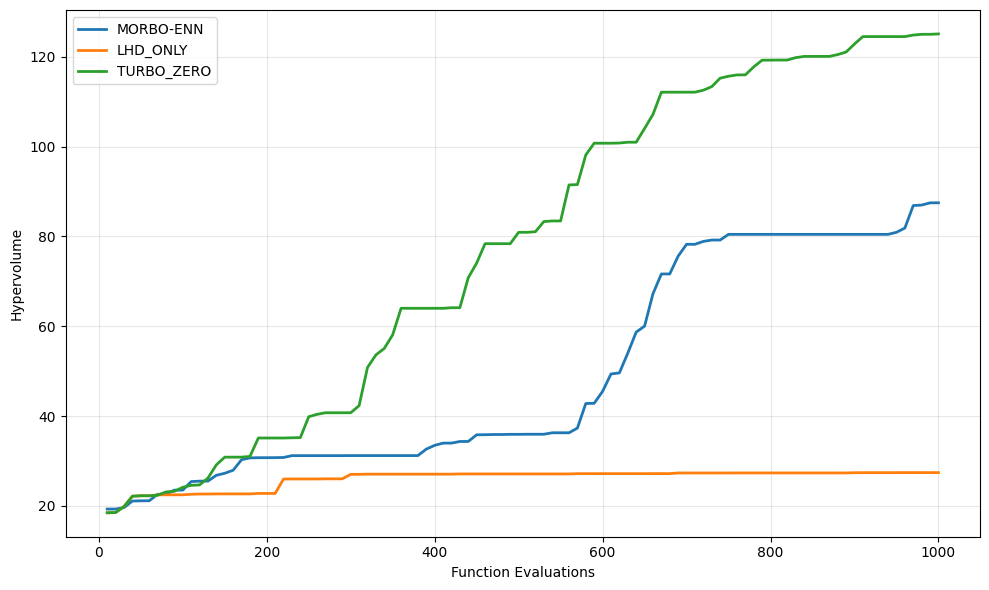

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for mode, data in results.items():
    plt.plot(data["evals"], data["hv"], linewidth=2, label=mode.value)
plt.xlabel("Function Evaluations")
plt.ylabel("Hypervolume")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Proposal Time vs Function Evaluations

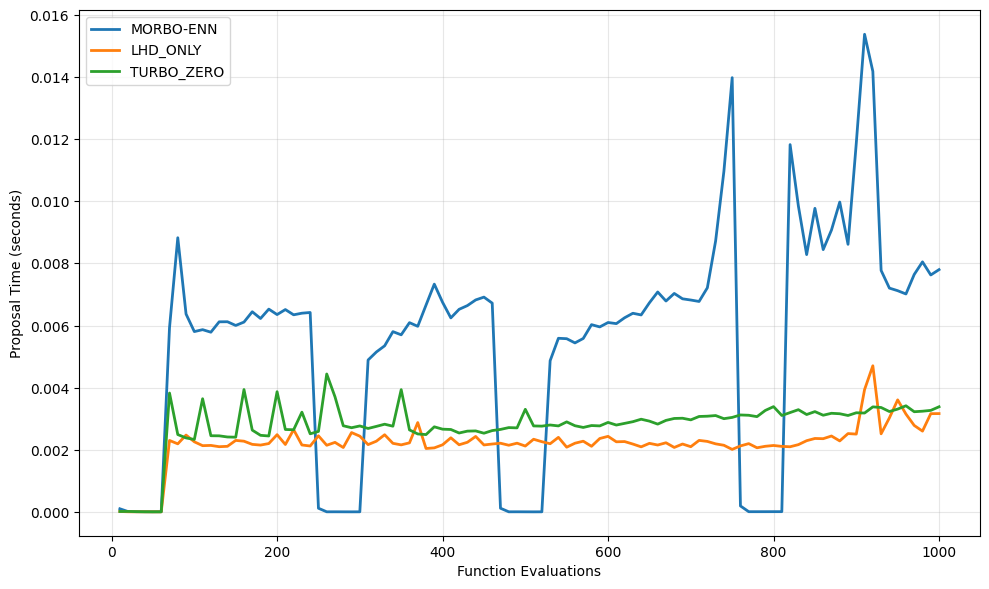

In [7]:
plt.figure(figsize=(10, 6))
for mode, data in results.items():
    plt.plot(data["evals"], data["times"], linewidth=2, label=mode.value)
plt.xlabel("Function Evaluations")
plt.ylabel("Proposal Time (seconds)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()